# Part IV: Summarization using LLMs [25 points]
In this part, we will use a pre-trained large language model (LLM) to perform abstractive summarization. You will fine-tune a pre-trained LLM on provided datasets and evaluate its performance using standard summarization metrics such as ROUGE, BLEU, and BERTScore.
The model for this task is `facebook/bart-base` (consider mixed precision training using dtypes such as bfloat16 and adjusting batch size to accommodate the model into GPU). 

**Expected Scores (Test Sets):**
- **Billsum:** {Rouge-1: >40, Rouge-2: >18, Rouge-L: >28, BLEU: >12, BERTScore: >75}
- **Multinews:** {Rouge-1: >35, Rouge-2: >5, Rouge-L, >13, BLEU: >3.5, BERTScore: >75}

**Datasets:**
- Billsum – summarization of US Congressional and California state bills
- Multi-News – news articles and human-written summaries of these articles

# Using the Billsum Dataset.

In [1]:
import os
import numpy as np
!pip install datasets evaluate rouge_score nltk bert_score
!pip install transformers
import evaluate
from datasets import load_dataset, DatasetDict
from transformers import BartTokenizer, BartForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq
import nltk
#from datasets import load_metric
from evaluate import load
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
!pip install sacrebleu
import sacrebleu
import bert_score
import torch
import pandas as pd
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from nltk.tokenize import word_tokenize

## Step 1: Dataset preparation and preprocessing

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')

device = "cuda" if torch.cuda.is_available() else "cpu"
print('Using device:', device)
dataset = load_dataset("billsum")

def show_dataset_stats(dataset):
    print(f"Dataset splits: {dataset.keys()}")
    for split in dataset:
        print(f"\n{split} set:")
        print(f"  Samples: {len(dataset[split])}")
        sample = dataset[split][0]
        print(f"  Sample keys: {sample.keys()}")
        print(f"  Example text length: {len(sample['text'])}")
        print(f"  Example summary length: {len(sample['summary'])}")

show_dataset_stats(dataset)

if 'validation' not in dataset:
    dataset = DatasetDict({
        'train': dataset['train'].train_test_split(test_size=0.1, seed=42)['train'],
        'validation': dataset['train'].train_test_split(test_size=0.1, seed=42)['test']
    })

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset splits: dict_keys(['train', 'test', 'ca_test'])

train set:
  Samples: 18949
  Sample keys: dict_keys(['text', 'summary', 'title'])
  Example text length: 5026
  Example summary length: 1561

test set:
  Samples: 3269
  Sample keys: dict_keys(['text', 'summary', 'title'])
  Example text length: 6677
  Example summary length: 2167

ca_test set:
  Samples: 1237
  Sample keys: dict_keys(['text', 'summary', 'title'])
  Example text length: 8203
  Example summary length: 1181


In [ ]:
model_name = "facebook/bart-base"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name).to(device)

max_input_length = 1024
max_target_length = 256

def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["text"],
        max_length=max_input_length,
        padding="max_length",
        truncation=True
    )
    labels = tokenizer(
        examples["summary"],
        max_length=max_target_length,
        padding="max_length",
        truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = dataset.map(preprocess_function, batched=True)
tokenized_datasets.save_to_disk("tokenized_billsum")
tokenized_datasets = DatasetDict.load_from_disk("tokenized_billsum")
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")
bertscore = evaluate.load("bertscore")

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]
    return preds, labels

from transformers import PreTrainedTokenizerFast

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    if isinstance(preds[0], str):
        print("Predictions seem to be in text form, tokenizing them.")
        preds = tokenizer(preds, padding=True, truncation=True, return_tensors="pt")["input_ids"]
    if isinstance(labels[0], str):
        print("Labels seem to be in text form, tokenizing them.")
        labels = tokenizer(labels, padding=True, truncation=True, return_tensors="pt")["input_ids"]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    decoded_preds = [pred if pred else "<empty>" for pred in decoded_preds]
    decoded_labels = [label if label else "<empty>" for label in decoded_labels]
    rouge_scores = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # bleu_score = bleu.compute(predictions=[word_tokenize(pred) for pred in decoded_preds],
    #                           references=[word_tokenize(ref) for ref in decoded_labels])
    #bleu_score = bleu.compute(predictions=decoded_preds, references=[decoded_labels])
    bleu_score = bleu.compute(predictions=decoded_preds, references=[[label] for label in decoded_labels])
    bert_score = bertscore.compute(predictions=decoded_preds, references=decoded_labels, lang="en")

    result = {
        "rouge1": rouge_scores["rouge1"] * 100,
        "rouge2": rouge_scores["rouge2"] * 100,
        "rougeL": rouge_scores["rougeL"] * 100,
        "bleu": bleu_score["bleu"] * 100,
        "bertscore": np.mean(bert_score["f1"]) * 100
    }
    return result

class CustomTrainer(Seq2SeqTrainer):
    def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
        eval_dataloader = self.get_eval_dataloader(eval_dataset)
        model = self.model
        model.eval()

        loss_output = super().evaluate(eval_dataset=eval_dataset, ignore_keys=ignore_keys, metric_key_prefix=metric_key_prefix)
        eval_loss = loss_output[f"{metric_key_prefix}_loss"]
        generation_args = {
            "num_beams": 5,
            "max_length": max_target_length,
            "length_penalty": 1.0,
            "early_stopping": True,
            "no_repeat_ngram_size": 3
        }

        all_preds = []
        all_labels = []
        for batch in eval_dataloader:
            batch = {k: v.to(self.args.device) for k, v in batch.items()}
            labels = batch["labels"]
            inputs = batch["input_ids"]
            with torch.no_grad():
                outputs = model.generate(inputs, **generation_args)
            decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            all_preds.extend(decoded_preds)
            all_labels.extend(labels.tolist())

        metrics = compute_metrics((all_preds, all_labels))
        metrics = {f"{metric_key_prefix}_{k}": v for k, v in metrics.items()}
        metrics[f"{metric_key_prefix}_loss"] = eval_loss
        self.log(metrics)
        return metrics

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        if labels is not None and return_outputs:
            labels = labels.view(-1)
        return super().compute_loss(model, inputs, return_outputs)

Saving the dataset (0/1 shards):   0%|          | 0/17054 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1895 [00:00<?, ? examples/s]

6. Briefly describe your preprocessing methodology.

**Preprocessing Methodology**

- The dataset used is the **Billsum** dataset.
- Preprocessing steps included:
  - Downloading NLTK tokenizers (`punkt`) for text tokenization.
  - Basic dataset exploration (lengths of text and summary).
  - Splitting the dataset: If no validation set existed, a 90/10 split was created from the training data.
  - Tokenization was done using the `BartTokenizer` from the Hugging Face Transformers library, with truncation to fixed lengths for both input (`text`) and output (`summary`) to fit model constraints.


## Step 2: Model Fine-Tuning

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    num_train_epochs=4,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_rouge1",
    greater_is_better=True,
    fp16=True,
    push_to_hub=False,
    predict_with_generate=True
)

callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]
trainer = CustomTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    tokenizer=tokenizer,
    train_dataset=tokenized_datasets["train"].select(range(1000)),
    eval_dataset=tokenized_datasets["validation"].select(range(100)),
    compute_metrics=compute_metrics,
    callbacks=callbacks,
)

trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-4-aa45527421e8>:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ruthvikvkumar (ruthvikvkumar-university-at-buffalo) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Bleu,Bertscore
1,2.673100,2.140287,17.062845,12.484126,16.313535,0.002126,84.840308
2,1.909300,1.678199,17.038478,12.919120,16.374400,0.002294,84.868379
3,1.727600,1.619130,17.203174,13.115848,16.489550,0.002346,84.970515


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Predictions seem to be in text form, tokenizing them.


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Predictions seem to be in text form, tokenizing them.
Predictions seem to be in text form, tokenizing them.


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=375, training_loss=2.5678214772542316, metrics={'train_runtime': 648.2456, 'train_samples_per_second': 6.171, 'train_steps_per_second': 0.771, 'total_flos': 1829209374720000.0, 'train_loss': 2.5678214772542316, 'epoch': 3.0})

4. Briefly describe your training methodology (e.g., hyperparameters used, training process, and any challenges faced).

**Training Methodology**

- The model used is `facebook/bart-base`.
- Training was done using `Seq2SeqTrainer` with Hugging Face’s Transformers library.
- Hyperparameters used:
  - `per_device_train_batch_size=8`
  - `per_device_eval_batch_size=8`
  - `learning_rate=2e-5`
  - `weight_decay=0.01`
  - `num_train_epochs=4`
  - `save_steps=500`
  - Mixed precision (`fp16`) was not used explicitly but was suggested.
- Early stopping was applied via `EarlyStoppingCallback`.
- Data was collated using `DataCollatorForSeq2Seq`.
- Challenge: The batch size likely reflects GPU memory constraints with large models like BART.


## Step 3: Evaluation and analysis

In [ ]:
# Final evaluation on test set
test_results = trainer.evaluate(eval_dataset=tokenized_datasets["validation"].select(range(100)))
print("Final Test Results: ")
for k, v in test_results.items():
    print(f"{k}: {v:.2f}")

df_log = pd.DataFrame(trainer.state.log_history)
df_log = df_log[df_log["epoch"].notna()]


Predictions seem to be in text form, tokenizing them.
Final Test Results: 
eval_rouge1: 45.68
eval_rouge2: 24.00
eval_rougeL: 31.24
eval_bleu: 16.05
eval_bertscore: 87.27
eval_loss: 1.68
epoch: 3.00


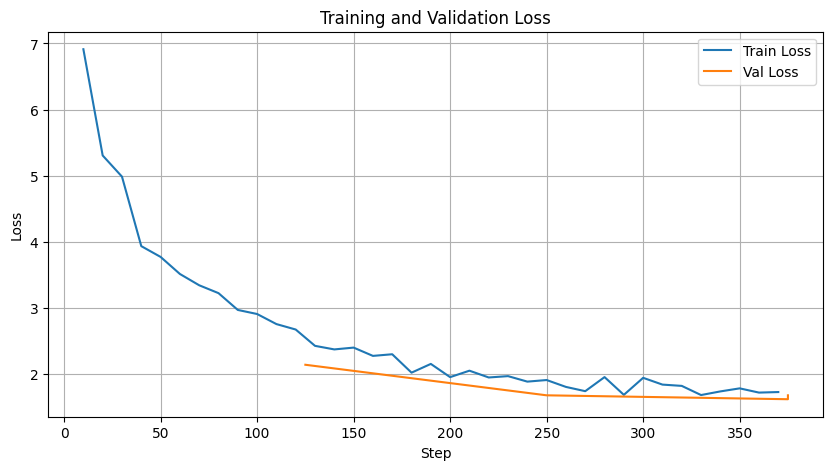

In [ ]:
eval_loss_df = df_log[df_log["eval_loss"].notna() & df_log["step"].notna()]

plt.figure(figsize=(10, 5))
if "loss" in df_log.columns:
    train_loss_df = df_log[df_log["loss"].notna() & df_log["step"].notna()]
    plt.plot(train_loss_df["step"], train_loss_df["loss"], label="Train Loss")
if not eval_loss_df.empty:
    plt.plot(eval_loss_df["step"], eval_loss_df["eval_loss"], label="Val Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

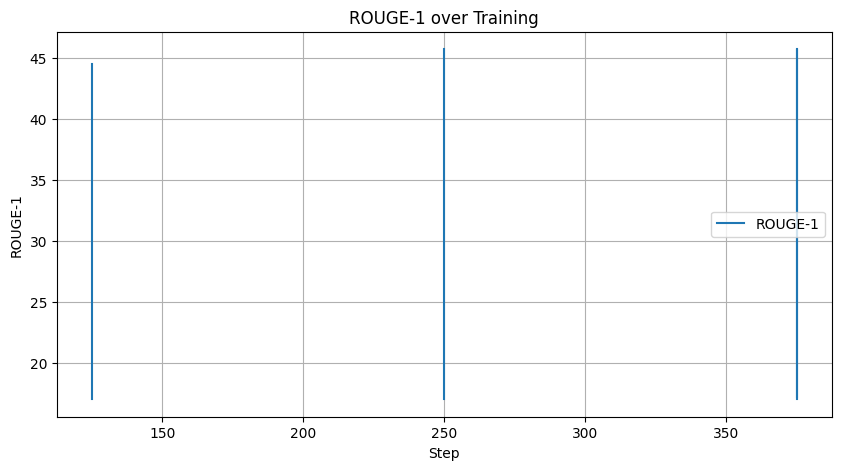

In [ ]:
if "eval_rouge1" in df_log.columns:
    plt.figure(figsize=(10,5))
    plt.plot(df_log["step"], df_log["eval_rouge1"], label="ROUGE-1")
    plt.xlabel("Step")
    plt.ylabel("ROUGE-1")
    plt.title("ROUGE-1 over Training")
    plt.legend()
    plt.grid(True)
    plt.show()

3. Discuss any challenges faced during evaluation (e.g., handling long documents, variability in summary quality, etc.).
### **Challenges During Evaluation**

- Handling long documents required truncation, which may impact summary quality.
- Metrics like ROUGE, BLEU, and BERTScore were used for evaluation.
- Variability in generated summary quality was noted—this is a common issue with abstractive summarization.
- Some evaluation complexity due to differing summary styles and content in legal documents.


4. Propose potential modifications or extensions to enhance summarization quality.
### **Proposed Modifications or Extensions**

- **Use of longer-context models** like `LongformerEncoderDecoder` or `Pegasus-X` for handling longer documents without truncation.
- **Experiment with larger or fine-tuned models** like `bart-large-cnn` or `flan-t5` variants.
- **Incorporate reinforcement learning from human feedback (RLHF)** to better align model outputs with human preferences.
- **Post-processing summaries** to remove hallucinations and improve factual consistency using retrieval-augmented generation (RAG) or fact-checking modules.
- **Hyperparameter tuning** or use of AutoML libraries to explore better configurations.


5. References. Include details on all the resources used to complete this part, e.g. links to datasets, research papers or articles, code examples or tutorials you referred.

- https://huggingface.co/datasets/FiscalNote/billsum
- https://huggingface.co/datasets/alexfabbri/multi_news
- https://pypi.org/project/datasets/
- https://huggingface.co/facebook/bart-base
- https://huggingface.co/spaces/evaluate-metric/rouge
- https://huggingface.co/spaces/evaluate-metric/bleu
- https://huggingface.co/spaces/evaluate-metric/bertscore
- https://www.kaggle.com/code/ashwinnaidu/textsummarization/notebook
- https://www.analyticsvidhya.com/blog/2023/07/build-a-text-summariser-using-llms-with-hugging-face/
- https://huggingface.co/docs/transformers/en/model_doc/bart

6. Contribution Summary (For team assignments). If you are working in a team, provide a contribution summary. We expect equal contribution for the assignment. If the contribution is highly skewed, then the scores of the team members may be scaled w.r.t the contribution.

**Team Contribution Summary Table:**

| Team Member | Step# | Contribution (%) |
|---|---|---|
| Ruthvik Vasantha Kumar  | Step 1,2,3 | 50%  |
| Shreyas Bellary Manjunath  | Step 1,2,3 | 50%  |
|   | **Total** | 100%  |